
TIME SERIES TRANSFORMER DEMO
This demo trains a Transformer to forecast synthetic time series.
Key features:
  - Encoder-decoder architecture
  - Scheduled sampling (gradual reduction of teacher forcing)
  - Mixed precision training (GPU acceleration)
  - Both teacher-forced and free-running evaluation

GENERATING SYNTHETIC DATA
Generated 120 series of length 320
Features shape: (120, 320, 4), Targets shape: (120, 320, 1)
Total windows: 34200 (history=24, forecast=12)
Train windows: 27360, Val windows: 6840

INITIALIZING MODEL
Model parameters: 796,545
Device: cuda
Mixed precision: BFloat16

TRAINING
Epoch 01 | p_tf=0.90 | train=0.5259 | val_tf=0.2216 | val_free=1.0892 | lr=9.62e-04
Epoch 02 | p_tf=0.84 | train=0.1597 | val_tf=0.1944 | val_free=0.9726 | lr=8.54e-04
Epoch 03 | p_tf=0.79 | train=0.1637 | val_tf=0.2027 | val_free=0.9744 | lr=6.91e-04
Epoch 04 | p_tf=0.73 | train=0.1416 | val_tf=0.1737 | val_free=0.4947 | lr=5.00e-04
Epoch 05 | p_tf=0.67 | train=0.1100 | val_tf=0.1574 | v

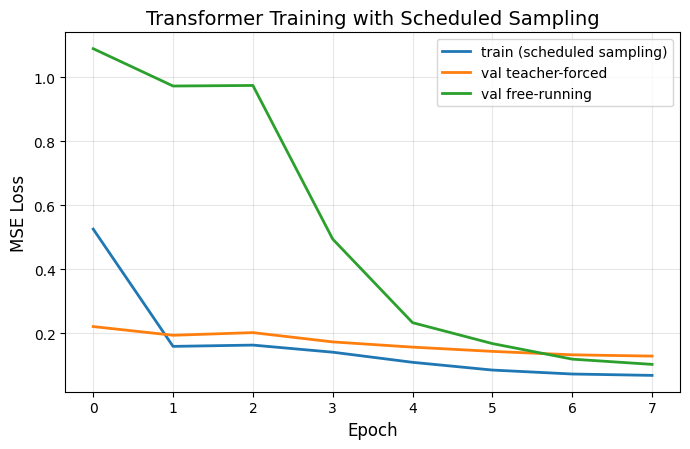


Key observations from training curves:
  1. Training loss (scheduled sampling) should decrease steadily
  2. val_tf (teacher-forced) is optimistic: decoder gets perfect inputs
  3. val_free (free-running) is realistic: decoder uses own predictions
  4. Gap between val_tf and val_free shows 'exposure bias'
  5. Scheduled sampling helps reduce this gap!

Generating forecast visualization...


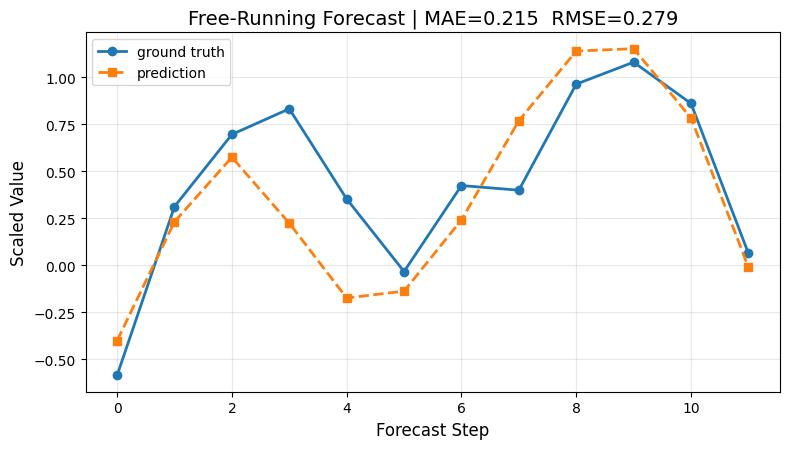


Forecast analysis:
  - MAE (Mean Absolute Error): 0.2149
  - RMSE (Root Mean Squared Error): 0.2788
  - Forecast horizon: 12 steps
  - History used: 24 steps

Notes:
  - This is ONE example forecast from the validation set
  - Errors typically grow with forecast horizon (drift accumulates)
  - Scheduled sampling helps maintain accuracy over longer horizons
  - For deployment, consider ensemble methods or recalibration

DEMO COMPLETE
Next steps for students:
  1. Experiment with different hyperparameters (d_model, num_layers, etc.)
  2. Try different teacher forcing schedules (exponential decay?)
  3. Add more features or change the synthetic data generation
  4. Implement attention visualization (see what the model focuses on)
  5. Test on real-world datasets (energy, weather, finance, etc.)
  6. Compare with baselines (ARIMA, Prophet, LSTM)



In [3]:
# ts_transformer_cuda_demo.py
# Educational Implementation: Transformer for Time Series Forecasting
# 
# This code demonstrates a complete sequence-to-sequence Transformer architecture
# for multi-step time series forecasting. It includes:
#   - Encoder-Decoder architecture with attention mechanisms
#   - Scheduled sampling (gradual reduction of teacher forcing)
#   - Mixed precision training (AMP) for GPU acceleration
#   - Both teacher-forced and free-running evaluation modes
#
# Key Concepts for Students:
#   1. Teacher Forcing: During training, we feed ground-truth previous outputs
#      to the decoder (even if the model would have predicted differently)
#   2. Scheduled Sampling: Gradually transition from teacher forcing to using
#      model predictions during training (bridges train-test gap)
#   3. Autoregressive Generation: At inference, the model generates step-by-step,
#      using its own predictions as inputs for the next step

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

# =============================================================================
#                       0) RUNTIME / DEVICE SETTINGS
# =============================================================================
# PEDAGOGICAL NOTE: Modern deep learning leverages GPU acceleration.
# This section configures PyTorch to use CUDA (NVIDIA GPUs) if available.

# Automatically detect and use GPU if available, otherwise fall back to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE == "cuda":
    # Enable cuDNN autotuner: finds the fastest convolution algorithms for your hardware
    # (Not critical for Transformers, but good practice for CNNs)
    torch.backends.cudnn.benchmark = True
    
    # Use TensorFloat-32 (TF32) for faster matrix multiplications on Ampere+ GPUs
    # TF32 trades a tiny bit of precision for ~8x speed improvement
    try:
        torch.set_float32_matmul_precision("high")  # options: "highest", "high", "medium"
    except Exception:
        pass  # Older PyTorch versions don't support this

# MIXED PRECISION TRAINING SETUP
# Why? Training in 16-bit (half precision) is ~2x faster and uses less memory
# than 32-bit (full precision), with minimal accuracy loss.
USE_AMP = (DEVICE == "cuda")                                 # Enable AMP only on GPU
USE_BF16 = USE_AMP and torch.cuda.is_bf16_supported()        # BFloat16 is more stable than Float16
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16    # Choose precision for autocast
SCALER_ENABLED = USE_AMP and (not USE_BF16)                  # GradScaler only needed for fp16

# REPRODUCIBILITY: Set random seeds for consistent results across runs
# Important for teaching: students can reproduce exact results
torch.manual_seed(7)
np.random.seed(7)

# =============================================================================
#                       1) ATTENTION MASK UTILITIES
# =============================================================================
# PEDAGOGICAL NOTE: Attention masks control which positions in the sequence
# can "see" each other. This is crucial for:
#   1. Causal masking: prevent the decoder from "cheating" by looking at future tokens
#   2. Padding masking: ignore padded positions in variable-length sequences

def subsequent_mask(sz: int) -> torch.Tensor:
    """
    Create a causal (look-ahead) mask for decoder self-attention.
    
    This mask ensures that position i can only attend to positions <= i,
    preventing the model from "seeing the future" during training.
    
    Visual example (sz=4):
        Position:  0  1  2  3
              0 [  F  T  T  T ]   Position 0 can only see itself
              1 [  F  F  T  T ]   Position 1 can see 0,1
              2 [  F  F  F  T ]   Position 2 can see 0,1,2
              3 [  F  F  F  F ]   Position 3 can see all (0,1,2,3)
    
    Args:
        sz: Sequence length (number of time steps)
    
    Returns:
        Boolean mask of shape [1, 1, sz, sz] where:
          - True  = BLOCK attention (can't see this position)
          - False = ALLOW attention (can see this position)
    
    Why this shape? [1, 1, sz, sz] broadcasts to [batch, heads, sz, sz]
    """
    # torch.triu creates upper triangular matrix; diagonal=1 excludes the main diagonal
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool, device="cpu"), diagonal=1)
    return mask.view(1, 1, sz, sz)  # Add batch and head dimensions for broadcasting


def merge_padding_mask(attn_shape: Tuple[int, int, int, int],
                       key_padding_mask: Optional[torch.Tensor]) -> Optional[torch.Tensor]:
    """
    Convert a key padding mask to attention score shape for broadcasting.
    
    Padding masks handle variable-length sequences by ignoring padding tokens.
    
    Example scenario:
        Batch of 2 sequences:
          Seq 1: [tok1, tok2, tok3, PAD, PAD]  length=3, padded to 5
          Seq 2: [tok1, tok2, tok3, tok4, tok5] length=5, no padding
        
        key_padding_mask = [[F, F, F, T, T],    # T = ignore these positions
                            [F, F, F, F, F]]
    
    Args:
        attn_shape: Target shape [batch, heads, query_len, key_len]
        key_padding_mask: [batch, key_len] where True = ignore this key position
    
    Returns:
        Mask broadcasted to [batch, heads, query_len, key_len], or None if no mask provided
    
    Why broadcast? Each query position needs to know which key positions are padding.
    """
    if key_padding_mask is None:
        return None
    
    b, t_k = key_padding_mask.shape
    _, h, t_q, _ = attn_shape
    
    # Reshape: [B, T_k] -> [B, 1, 1, T_k] then expand to [B, H, T_q, T_k]
    return key_padding_mask.view(b, 1, 1, t_k).expand(b, h, t_q, t_k)

# =============================================================================
#                       2) POSITIONAL ENCODINGS
# =============================================================================
# PEDAGOGICAL NOTE: Transformers have no inherent notion of position/order.
# Without positional encodings, "I love cats" = "cats love I" to the model!
# We add position information in two ways:

class SinusoidalPositionalEncoding(nn.Module):
    """
    Fixed sinusoidal positional encoding (original "Attention Is All You Need" paper).
    
    Key idea: Use sine and cosine functions of different frequencies to encode position.
    
    Why sinusoidal?
      1. Smooth, continuous encoding (nearby positions have similar encodings)
      2. Can extrapolate to longer sequences than seen in training
      3. No parameters to learn (reduces model complexity)
    
    Formula for position pos and dimension i:
        PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    Intuition: Low dimensions oscillate fast (capture fine details),
               high dimensions oscillate slowly (capture coarse structure)
    
    Args:
        d_model: Embedding dimension (must match model hidden size)
        max_len: Maximum sequence length we might encounter
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        
        # Pre-compute positional encodings for all possible positions
        pe = torch.zeros(max_len, d_model)
        
        # Position indices: [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Compute division term: 10000^(2i/d_model) for each dimension pair
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) * 
            -(math.log(10000.0) / d_model)
        )
        
        # Apply sine to even dimensions (0, 2, 4, ...)
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd dimensions (1, 3, 5, ...)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer: saved with model but not trained (no gradients)
        self.register_buffer("pe", pe, persistent=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input embeddings.
        
        Args:
            x: Input tensor [batch, seq_len, d_model]
        
        Returns:
            x + positional_encoding, same shape as input
        """
        T = x.size(1)  # Sequence length
        # Slice out the needed positions and add to input (broadcasting over batch)
        return x + self.pe[:T, :]


class LearnedPositionalEncoding(nn.Module):
    """
    Learned positional embeddings (trainable alternative to sinusoidal).
    
    Key idea: Let the model learn optimal position representations from data.
    
    Pros:
      - Can learn task-specific position patterns
      - Often performs slightly better on the specific task
    
    Cons:
      - Cannot extrapolate beyond max_len seen in training
      - Adds parameters to the model (max_len * d_model weights)
    
    Args:
        d_model: Embedding dimension
        max_len: Maximum sequence length (model can't handle longer sequences)
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        # Create a lookup table: position ID -> embedding vector
        self.embed = nn.Embedding(max_len, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add learned positional embedding to input.
        
        Args:
            x: Input tensor [batch, seq_len, d_model]
        
        Returns:
            x + learned_position_embedding
        """
        B, T, _ = x.shape
        # Create position IDs: [0, 1, 2, ..., T-1] for each batch item
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        return x + self.embed(pos)

# =============================================================================
#                       3) TRANSFORMER BUILDING BLOCKS
# =============================================================================
# PEDAGOGICAL NOTE: Transformers are built from repeated layers of:
#   1. Multi-Head Attention (the "magic sauce" - learns relationships)
#   2. Feed-Forward Networks (processes each position independently)
#   3. Residual Connections + Layer Normalization (training stability)

class PreNormResidual(nn.Module):
    """
    Pre-normalization residual wrapper: a modern, stable Transformer design pattern.
    
    Flow: x -> LayerNorm -> Block -> Dropout -> (+) x
                                                  ↑
                                            residual
    
    Why Pre-Norm (vs. Post-Norm)?
      - More stable gradients (especially for deep networks)
      - Can often train without learning rate warmup
      - Original Transformer used Post-Norm, but Pre-Norm is now standard
    
    Why Residual Connections?
      - Allow gradients to flow directly through the network
      - Help train very deep networks (50+ layers)
      - Let early layers pass information directly to later layers
    
    Args:
        d_model: Model dimension
        block: The actual computation (attention or feedforward)
        dropout: Probability of dropping activations (regularization)
    """
    def __init__(self, d_model: int, block: nn.Module, dropout: float = 0.0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)  # Normalize over feature dimension
        self.block = block                  # Multi-head attention or feedforward
        self.drop = nn.Dropout(dropout)     # Randomly zero some activations
    
    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        """
        Apply: residual + dropout(block(norm(x)))
        
        Args:
            x: Input tensor [batch, seq_len, d_model]
            *args, **kwargs: Passed to the block (e.g., attention masks)
        
        Returns:
            Output with same shape as input
        """
        # Normalize first, compute block, dropout, then add residual
        return x + self.drop(self.block(self.norm(x), *args, **kwargs))


class FeedForward(nn.Module):
    """
    Position-wise feedforward network: processes each position independently.
    
    Architecture: Linear -> Activation -> Dropout -> Linear
                   (expand)                        (compress)
    
    Why this design?
      - Expands to higher dimension (d_ff, typically 4*d_model) for expressiveness
      - Non-linear activation allows learning complex patterns
      - Compresses back to original dimension
      - Applied identically to each position (no cross-position interaction)
    
    Think of it as: each position gets passed through a small 2-layer MLP.
    
    Args:
        d_model: Input/output dimension
        d_ff: Hidden dimension (typically 2048 or 4*d_model)
        dropout: Dropout probability after activation
        activation: "gelu" (smooth) or "relu" (traditional)
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0, activation: str = "gelu"):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)    # Expand dimension
        self.lin2 = nn.Linear(d_ff, d_model)    # Compress back
        self.drop = nn.Dropout(dropout)
        # GELU is smoother than ReLU, often works better in Transformers
        self.act = F.gelu if activation == "gelu" else F.relu
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            Same shape as input
        """
        # Expand -> activate -> dropout -> compress
        return self.lin2(self.drop(self.act(self.lin1(x))))


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention: the core mechanism that makes Transformers powerful.
    
    KEY INTUITION:
        Attention lets each position "look at" other positions and decide
        what information to pull from them. Multi-head attention runs
        several attention operations in parallel (different "heads"),
        each potentially learning different relationships.
    
    Example: In "The cat sat on the mat", when processing "sat":
      - Head 1 might focus on "cat" (subject)
      - Head 2 might focus on "mat" (object)
      - Head 3 might focus on "on" (preposition)
    
    MECHANISM:
      1. Project inputs to Query (Q), Key (K), Value (V) spaces
      2. Split into multiple heads (num_heads parallel attention operations)
      3. Compute attention scores: how much should each position attend to others?
         score(q, k) = (q · k) / sqrt(d_head)  [scaled dot-product]
      4. Apply softmax to get attention weights (sum to 1)
      5. Weighted sum of Values: output = Σ attention_weight * value
      6. Concatenate heads and project back to d_model
    
    Args:
        d_model: Total model dimension (must be divisible by num_heads)
        num_heads: Number of parallel attention operations
        dropout: Dropout applied to attention weights
        bias: Whether to use bias in linear projections
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.h = num_heads
        self.d_head = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V (one per input role)
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        
        # Output projection (combine all heads)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)
        
        # Dropout for regularization
        self.drop = nn.Dropout(dropout)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Split the embedding dimension into multiple heads.
        
        Reshape: [B, T, D] -> [B, T, H, D/H] -> [B, H, T, D/H]
        
        Why? We want to compute H separate attention operations in parallel.
        Moving H to dimension 1 allows efficient batched matrix operations.
        """
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_head).permute(0, 2, 1, 3)

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        Merge multiple heads back into single embedding.
        
        Reshape: [B, H, T, D/H] -> [B, T, H, D/H] -> [B, T, D]
        
        Concatenates all head outputs into the original d_model dimension.
        """
        B, H, T, Dh = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None) -> torch.Tensor:
        """
        Compute multi-head attention.
        
        Args:
            q: Query tensor [batch, seq_len_q, d_model]
            k: Key tensor [batch, seq_len_k, d_model]
            v: Value tensor [batch, seq_len_k, d_model]
            attn_mask: Attention mask [1, 1, seq_len_q, seq_len_k] (e.g., causal mask)
            key_padding_mask: Padding mask [batch, seq_len_k] (True = ignore this position)
        
        Returns:
            Attention output [batch, seq_len_q, d_model]
        
        Note: For self-attention, q=k=v (same sequence attends to itself)
              For cross-attention, q comes from decoder, k=v from encoder
        """
        # Project and split into heads
        Q = self._split_heads(self.q_proj(q))  # [B, H, T_q, D/H]
        K = self._split_heads(self.k_proj(k))  # [B, H, T_k, D/H]
        V = self._split_heads(self.v_proj(v))  # [B, H, T_k, D/H]

        # SCALED DOT-PRODUCT ATTENTION
        # Compute attention scores: how much should each query attend to each key?
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)
        # Shape: [B, H, T_q, T_k]
        # Scaling by sqrt(d_head) prevents softmax saturation (gradients vanish)

        # Use finfo.min instead of -inf for numerical stability in half precision
        neg_inf = torch.finfo(scores.dtype).min

        # APPLY MASKS
        # Key padding mask: ignore padded positions in the key sequence
        if key_padding_mask is not None:
            kpm = merge_padding_mask(scores.shape, key_padding_mask)
            scores = scores.masked_fill(kpm, neg_inf)  # Set to very negative -> softmax ~0

        # Attention mask: prevent attending to certain positions (e.g., future tokens)
        if attn_mask is not None:
            if attn_mask.device != scores.device:
                attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask, neg_inf)

        # Compute attention weights (softmax over key dimension)
        attn = torch.softmax(scores, dim=-1)  # [B, H, T_q, T_k]
        attn = self.drop(attn)  # Dropout for regularization
        
        # Weighted sum of values
        out = torch.matmul(attn, V)  # [B, H, T_q, D/H]
        
        # Combine heads and project
        out = self._combine_heads(out)  # [B, T_q, D]
        return self.o_proj(out)


class EncoderLayer(nn.Module):
    """
    Single Transformer encoder layer.
    
    Architecture:
      1. Multi-Head Self-Attention (each position attends to all positions)
      2. Feedforward Network (process each position independently)
    
    Both wrapped in PreNormResidual blocks for stability.
    
    Purpose: Build representations that incorporate context from the entire sequence.
    
    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        # Self-attention: sequence attends to itself
        self.mha = PreNormResidual(
            d_model, 
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model, 
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )
    
    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input sequence [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]
        
        Returns:
            Encoded sequence [batch, seq_len, d_model]
        """
        # Self-attention: q=k=v=x
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        # Feedforward
        x = self.ffn(x)
        return x


class DecoderLayer(nn.Module):
    """
    Single Transformer decoder layer.
    
    Architecture:
      1. Masked Self-Attention (causal: can't see future)
      2. Cross-Attention (attend to encoder output)
      3. Feedforward Network
    
    All wrapped in PreNormResidual blocks.
    
    Purpose: Generate output sequence one step at a time, using:
      - What we've generated so far (self-attention)
      - Information from the input sequence (cross-attention)
    
    Args:
        d_model: Model dimension
        num_heads: Number of attention heads
        d_ff: Feedforward hidden dimension
        attn_dropout: Dropout for attention
        ff_dropout: Dropout for feedforward
        activation: Activation function type
    """
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        # Causal self-attention: decoder attends to its own past
        self.self_attn = PreNormResidual(
            d_model, 
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Cross-attention: decoder attends to encoder output
        self.cross_attn = PreNormResidual(
            d_model, 
            MultiHeadAttention(d_model, num_heads, attn_dropout)
        )
        # Position-wise feedforward
        self.ffn = PreNormResidual(
            d_model, 
            FeedForward(d_model, d_ff, ff_dropout, activation)
        )
    
    def forward(self, x, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        """
        Args:
            x: Decoder input sequence [batch, seq_len, d_model]
            mem: Encoder output (memory) [batch, src_len, d_model]
            self_attn_mask: Causal mask for decoder self-attention
            self_key_padding_mask: Padding mask for decoder sequence
            mem_key_padding_mask: Padding mask for encoder sequence
        
        Returns:
            Decoded sequence [batch, seq_len, d_model]
        """
        # 1. Causal self-attention: look at past decoder outputs
        x = self.self_attn(x, x, x, attn_mask=self_attn_mask, key_padding_mask=self_key_padding_mask)
        
        # 2. Cross-attention: look at encoder outputs
        #    Query from decoder, Key/Value from encoder
        x = self.cross_attn(x, mem, mem, attn_mask=None, key_padding_mask=mem_key_padding_mask)
        
        # 3. Feedforward processing
        x = self.ffn(x)
        return x


class Encoder(nn.Module):
    """
    Stack of encoder layers + final layer normalization.
    
    Purpose: Process the input sequence to build rich representations
    that capture context and relationships.
    
    Args:
        d_model: Model dimension
        num_layers: Number of encoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout) 
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization
    
    def forward(self, x, key_padding_mask=None):
        """
        Args:
            x: Input embeddings [batch, seq_len, d_model]
            key_padding_mask: Padding mask [batch, seq_len]
        
        Returns:
            Encoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)


class Decoder(nn.Module):
    """
    Stack of decoder layers + final layer normalization.
    
    Purpose: Generate output sequence autoregressively,
    conditioned on encoder output.
    
    Args:
        d_model: Model dimension
        num_layers: Number of decoder layers to stack
        num_heads: Number of attention heads per layer
        d_ff: Feedforward hidden dimension
        attn_dropout: Attention dropout
        ff_dropout: Feedforward dropout
    """
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout) 
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)  # Final normalization
    
    def forward(self, y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        """
        Args:
            y: Decoder input sequence [batch, seq_len, d_model]
            mem: Encoder output [batch, src_len, d_model]
            self_attn_mask: Causal mask
            self_key_padding_mask: Decoder padding mask
            mem_key_padding_mask: Encoder padding mask
        
        Returns:
            Decoded representations [batch, seq_len, d_model]
        """
        for layer in self.layers:
            y = layer(y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask)
        return self.norm(y)

# =============================================================================
#                       4) COMPLETE MODEL (ENC + DEC)
# =============================================================================

@dataclass
class TSTConfig:
    """
    Configuration for Time Series Transformer.
    
    Architecture hyperparameters:
        d_model: Hidden dimension throughout the model (like "brain size")
        num_encoder_layers: Depth of encoder (more = more context integration)
        num_decoder_layers: Depth of decoder (fewer than encoder is common)
        num_heads: Parallel attention operations (more = capture more relationships)
        d_ff: Feedforward expansion dimension (typically 4*d_model)
        dropout: Regularization strength (0.0 = none, 0.3 = aggressive)
    
    Input/output specification:
        input_dim: Number of input features (e.g., temperature, pressure, etc.)
        target_dim: Number of values to predict (often 1 for univariate forecasting)
        dec_input_dim: Decoder input size (should match target_dim for simplicity)
    
    Other settings:
        pos_encoding: "sin" (fixed) or "learned" (trainable)
        max_len: Maximum sequence length
        output_activation: Optional final activation ("tanh", "sigmoid", or None)
    """
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"  # "sin" or "learned"
    max_len: int = 4096
    input_dim: int = 4         # number of historical features
    target_dim: int = 1        # we forecast a single target value
    dec_input_dim: int = 1     # decoder input size (shifted target)
    output_activation: Optional[str] = None  # e.g., "tanh" for bounded target


class TimeSeriesTransformer(nn.Module):
    """
    Complete Sequence-to-Sequence Transformer for Time Series Forecasting.
    
    ARCHITECTURE OVERVIEW:
      Input (history) → Encoder → Memory
                                     ↓
      Previous outputs → Decoder → Next prediction
    
    KEY CONCEPTS:
      1. ENCODER: Processes historical data (e.g., past 24 hours)
         - Builds rich representations that capture patterns and context
         - Output = "memory" that decoder can attend to
      
      2. DECODER: Generates future predictions (e.g., next 12 hours)
         - Autoregressively: generates one step at a time
         - Uses both its own past predictions AND encoder memory
      
      3. TEACHER FORCING (training): Feed ground-truth previous values to decoder
         - Fast: can train all steps in parallel
         - Problem: decoder never sees its own mistakes during training
      
      4. AUTOREGRESSIVE GENERATION (inference): Feed model's own predictions
         - Slow: must generate step-by-step
         - Realistic: matches deployment scenario
    
    EXAMPLE:
      History: [hour 1, hour 2, ..., hour 24] → Encoder
      Decoder generates: [hour 25, hour 26, ..., hour 36]
        - To predict hour 26, decoder sees: hour 25 (either ground-truth or its prediction)
        - To predict hour 27, decoder sees: hours 25-26
        - And so on...
    
    Args:
        cfg: Configuration object with all hyperparameters
    """
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg
        
        # INPUT PROJECTIONS: Convert raw features to model dimension
        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)      # Encoder input projection
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)  # Decoder input projection

        # POSITIONAL ENCODINGS: Add position information to embeddings
        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        # ENCODER & DECODER STACKS
        self.enc = Encoder(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        
        # OUTPUT HEAD: Project decoder output to prediction space
        self.head = nn.Linear(cfg.d_model, cfg.target_dim)
        
        # INPUT DROPOUT: Regularization on embeddings
        self.drop_in = nn.Dropout(cfg.dropout)

        # OPTIONAL OUTPUT ACTIVATION: Constrain predictions to a range
        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh      # Range: [-1, 1]
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid   # Range: [0, 1]

    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Teacher-forced forward pass (for training).
        
        TRAINING MODE: We give the decoder the ground-truth previous outputs.
        This allows parallel computation (fast!) but creates train-test mismatch.
        
        Flow:
          1. Encode history: X → embeddings → encoder → memory
          2. Decode with teacher forcing: y_in → embeddings → decoder → predictions
          3. Project to output space: predictions → final forecasts
        
        Args:
            X: Historical features [batch, history_len, input_dim]
               Example shape: [32, 24, 4] = 32 sequences, 24 timesteps, 4 features
            
            y_in: Decoder inputs (shifted targets) [batch, forecast_len, dec_input_dim]
                  IMPORTANT: y_in[0] = start token (often 0 or last observed value)
                             y_in[1] = ground-truth target at step 0
                             y_in[2] = ground-truth target at step 1
                             ... (shifted right by 1)
            
            src_key_padding_mask: Padding mask for encoder [batch, history_len]
            tgt_key_padding_mask: Padding mask for decoder [batch, forecast_len]
        
        Returns:
            Predictions [batch, forecast_len, target_dim]
            
        TEACHER FORCING VISUALIZATION:
          Ground truth: [y₀, y₁, y₂, y₃]
          Decoder input: [START, y₀, y₁, y₂]  (shifted right)
          Predictions:   [ŷ₀, ŷ₁, ŷ₂, ŷ₃]
          Loss: compare predictions to ground truth
        """
        # ENCODE HISTORY
        x = self.drop_in(self.pos_enc(self.enc_in(X)))  # Project → positional encoding → dropout
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)  # Run through encoder

        # DECODE WITH TEACHER FORCING
        y = self.drop_in(self.pos_dec(self.dec_in(y_in)))  # Process decoder inputs
        self_mask = subsequent_mask(y.size(1)).to(y.device)  # Causal mask: can't see future
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)
        
        # PROJECT TO OUTPUT SPACE
        logits = self.head(out)  # [batch, forecast_len, target_dim]
        
        # Apply output activation if specified
        return logits if self.out_act is None else self.out_act(logits)

    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        """
        Autoregressive generation (for inference/deployment).
        
        INFERENCE MODE: Decoder uses its own predictions (no ground truth available).
        This is slow (sequential) but realistic for deployment.
        
        Process:
          1. Encode history once (doesn't change)
          2. Start with initial token (y_start)
          3. For each step:
             a. Decode current sequence
             b. Predict next value
             c. Append prediction to sequence
             d. Repeat
        
        Args:
            X: Historical features [batch, history_len, input_dim]
            y_start: Initial decoder token [batch, 1, dec_input_dim]
                     Often: last observed target value or a zero vector
            steps: Number of future steps to predict
            src_key_padding_mask: Padding mask for encoder
        
        Returns:
            Predictions [batch, steps, target_dim]
        
        AUTOREGRESSIVE VISUALIZATION:
          Step 1: [START]           → predict ŷ₀
          Step 2: [START, ŷ₀]       → predict ŷ₁
          Step 3: [START, ŷ₀, ŷ₁]   → predict ŷ₂
          Step 4: [START, ŷ₀, ŷ₁, ŷ₂] → predict ŷ₃
          ...
        
        Note: Errors compound! If ŷ₀ is wrong, all future predictions are affected.
        """
        device = X.device
        
        # ENCODE HISTORY (once)
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)

        preds = []
        y_seq = y_start  # Start with initial token; will grow each step

        # AUTOREGRESSIVE LOOP
        for _ in range(steps):
            # Decode current sequence
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)
            
            # Predict next value (only use last position's output)
            next_logits = self.head(out[:, -1:, :])  # [batch, 1, target_dim]
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)

            # APPEND PREDICTION TO SEQUENCE (for next iteration)
            # Handle dimension mismatch if dec_input_dim != target_dim
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    # Pad prediction to match decoder input size
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    # Truncate prediction to match decoder input size
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)

        return torch.cat(preds, dim=1)  # [batch, steps, target_dim]

# =============================================================================
#                       5) SYNTHETIC DATASET (TEACHING-FRIENDLY)
# =============================================================================

def make_sine_mix(n_series: int, length: int, n_features: int, seed: int = 0):
    """
    Generate synthetic time series data for educational purposes.
    
    WHY SYNTHETIC DATA?
      - Controlled: we know the true patterns
      - Reproducible: same seed = same data
      - Simple: easy to visualize and understand
      - Fast: no need to download large datasets
    
    GENERATION PROCESS:
      1. Create base signal: sum of 2 sine waves with random frequencies
      2. Add linear trend + noise for realism
      3. Generate 4 features from base signal:
         - feat0: base signal itself
         - feat1: cosine wave (phase-shifted)
         - feat2: lagged version of base (simple temporal dependency)
         - feat3: quadratic term (non-linear relationship)
      4. Target: tanh(base + 0.1*cosine) to create bounded, smooth target
      5. Standardize: zero mean, unit variance (helps training stability)
    
    Args:
        n_series: Number of independent time series to generate
        length: Number of timesteps per series
        n_features: Number of features to include (1-4)
        seed: Random seed for reproducibility
    
    Returns:
        X: Features [n_series, length, n_features]
        y: Targets [n_series, length, 1]
        stats: Dictionary with normalization statistics
    """
    rng = np.random.default_rng(seed)
    t = np.arange(length)  # Time indices
    
    # Initialize arrays
    X = np.zeros((n_series, length, n_features), dtype=np.float32)
    y = np.zeros((n_series, length, 1), dtype=np.float32)

    # GENERATE EACH TIME SERIES
    for i in range(n_series):
        # Random frequencies for sine waves (different patterns per series)
        f1, f2 = rng.uniform(0.01, 0.08), rng.uniform(0.08, 0.15)
        # Random phases (different starting points)
        p1, p2 = rng.uniform(0, 2*np.pi), rng.uniform(0, 2*np.pi)
        # Small random trend (upward or downward)
        trend = rng.uniform(-0.002, 0.002) * t
        # Gaussian noise for realism
        noise = rng.normal(0, 0.05, size=length)
        
        # BASE SIGNAL: sum of two sine waves
        base = 0.6*np.sin(2*np.pi*f1*t + p1) + 0.4*np.sin(2*np.pi*f2*t + p2) + trend + noise

        # CREATE FEATURES
        feat0 = base                              # Original signal
        feat1 = np.cos(2*np.pi*0.03*t + p1)      # Cosine (different phase)
        feat2 = np.roll(base, 3)                  # Lagged signal (shift by 3 steps)
        feat3 = 0.5*(base**2)                     # Quadratic term (non-linearity)

        # Stack features and keep only first n_features
        feats = np.stack([feat0, feat1, feat2, feat3], axis=-1).astype(np.float32)[:, :n_features]
        X[i] = feats
        
        # TARGET: bounded transformation of base signal
        y[i, :, 0] = np.tanh(base + 0.1*feat1).astype(np.float32)

    # STANDARDIZATION: critical for training stability
    # Why? Large/varying scales → unstable gradients, slow convergence
    X_mean = X.mean(axis=(0,1), keepdims=True)  # Mean over all samples and timesteps
    X_std  = X.std(axis=(0,1), keepdims=True) + 1e-6  # +epsilon to avoid division by zero
    y_mean = y.mean(axis=(0,1), keepdims=True)
    y_std  = y.std(axis=(0,1), keepdims=True) + 1e-6
    
    X = (X - X_mean) / X_std  # Zero mean, unit variance
    y = (y - y_mean) / y_std
    
    return X, y, {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}


class WindowedTS(Dataset):
    """
    PyTorch Dataset for sliding window forecasting.
    
    CONCEPT: Long time series → many overlapping windows
    
    Example with history=3, forecast=2:
      Series: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      
      Window 1: history=[0,1,2], forecast=[3,4]
      Window 2: history=[1,2,3], forecast=[4,5]
      Window 3: history=[2,3,4], forecast=[5,6]
      ... and so on
    
    This creates many training examples from a single long series!
    
    Returns (for each window):
        Xw: Historical features [history_len, n_features]
        y_in: Decoder inputs (teacher forcing) [forecast_len, 1]
              First token = 0 (start token)
              Remaining tokens = shifted ground-truth targets
        y_true: Ground-truth future targets [forecast_len, 1]
    
    Args:
        X: All features [n_series, series_length, n_features]
        y: All targets [n_series, series_length, 1]
        T_x: History length (how much past to use)
        T_y: Forecast horizon (how far ahead to predict)
    """
    def __init__(self, X, y, T_x: int, T_y: int):
        self.X = X
        self.y = y
        self.T_x = T_x  # History window size
        self.T_y = T_y  # Forecast horizon
        self.length = X.shape[1]
        
        # BUILD INDEX: list of all valid (series_id, start_time) pairs
        self.index = []
        for i in range(X.shape[0]):  # For each series
            # For each valid starting position
            for t in range(self.length - (T_x + T_y) + 1):
                self.index.append((i, t))
        
        # Total windows = n_series * (series_length - T_x - T_y + 1)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """
        Extract one training window.
        
        Returns:
            Xw: Historical window [T_x, n_features]
            y_in: Decoder inputs [T_y, 1] (shifted targets with start token)
            y_future: Ground-truth targets [T_y, 1]
        """
        i, t = self.index[idx]  # Which series, which starting time
        
        # EXTRACT HISTORY
        Xw = self.X[i, t:t+self.T_x, :].copy()  # [T_x, n_features]
        
        # EXTRACT FUTURE TARGETS
        y_future = self.y[i, t+self.T_x:t+self.T_x+self.T_y, :].copy()  # [T_y, 1]

        # CREATE TEACHER FORCING INPUTS (shifted right by 1)
        y_in = np.zeros((self.T_y, 1), dtype=np.float32)
        y_in[1:, 0] = y_future[:-1, 0]  # Shift: positions 1..T_y get targets 0..T_y-1
        # y_in[0] = 0 (start token)
        
        return torch.from_numpy(Xw), torch.from_numpy(y_in), torch.from_numpy(y_future)

# =============================================================================
#                       6) SCHEDULED SAMPLING (TEACHER FORCING PROBABILITY)
# =============================================================================

@torch.no_grad()
def _bernoulli_mask(batch: int, p_tf: float, device):
    """
    Sample a random mask for scheduled sampling.
    
    Creates a per-sample binary decision: use teacher forcing or model prediction?
    
    Args:
        batch: Batch size
        p_tf: Probability of using teacher forcing (0.0 = never, 1.0 = always)
        device: torch device
    
    Returns:
        Boolean mask [batch, 1, 1] where:
          True  = use ground-truth (teacher forcing)
          False = use model prediction
    
    Example with p_tf=0.7, batch=4:
      Output might be: [[True], [True], [False], [True]]
      → 3 samples use teacher forcing, 1 uses its own prediction
    """
    return (torch.rand(batch, 1, 1, device=device) < p_tf)


def scheduled_sampling_step(
    model: TimeSeriesTransformer,
    Xb: torch.Tensor,           # [batch, history_len, n_features]
    ytrue: torch.Tensor,        # [batch, forecast_len, target_dim]
    p_tf: float,                # teacher forcing probability ∈ [0, 1]
) -> torch.Tensor:
    """
    Autoregressive training with scheduled sampling.
    
    THE EXPOSURE BIAS PROBLEM:
      - Training with teacher forcing: decoder always sees perfect inputs
      - Testing (inference): decoder sees its own (imperfect) predictions
      - Result: model performs worse at test time than training suggests!
    
    SOLUTION: Scheduled Sampling
      - During training, randomly mix ground-truth and model predictions
      - Gradually decrease teacher forcing probability over training
      - Decoder learns to handle its own mistakes
    
    ALGORITHM:
      For each forecast step t:
        1. Decode current sequence → predict next value
        2. Randomly choose (with probability p_tf):
           - Use ground-truth target (teacher forcing)
           - Use model's prediction (self-correction)
        3. Append chosen value to decoder input
        4. Repeat for next step
    
    Args:
        model: TimeSeriesTransformer instance
        Xb: Historical features [batch, history_len, n_features]
        ytrue: Ground-truth targets [batch, forecast_len, target_dim]
        p_tf: Teacher forcing probability
              p_tf=1.0 → always use ground truth (standard teacher forcing)
              p_tf=0.5 → 50/50 mix of ground truth and predictions
              p_tf=0.0 → always use predictions (free-running)
              p_tf=0.0 → always use predictions (free-running)
    
    Returns:
        Predictions [batch, forecast_len, target_dim] in float32
    
    Note: Assumes dec_input_dim == target_dim for simplicity
    """
    assert model.cfg.dec_input_dim == model.cfg.target_dim == ytrue.size(-1), \
        "scheduled_sampling_step assumes dec_input_dim == target_dim."
    device = Xb.device
    B, T_y, C = ytrue.shape

    # ENCODE HISTORY (once, doesn't change during generation)
    x = model.pos_enc(model.enc_in(Xb))         # [batch, history_len, d_model]
    mem = model.enc(x, key_padding_mask=None)   # Encoder output (memory)

    preds = []
    # SEED: Start decoder with first ground-truth target
    # (Alternative: use last observed value from history)
    y_seq = ytrue[:, :1, :]                     # [batch, 1, target_dim]

    # AUTOREGRESSIVE LOOP WITH SCHEDULED SAMPLING
    # Mixed precision for speed (automatic on GPU)
    with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
        for t in range(T_y):
            # DECODE current prefix
            y_dec = model.pos_dec(model.dec_in(y_seq))          # Add positional encoding
            self_mask = subsequent_mask(y_dec.size(1)).to(device)  # Causal mask
            out = model.dec(y_dec, mem, self_mask, None, None)  # Decoder forward
            
            # PREDICT next value
            step_pred = model.head(out[:, -1:, :])              # Project last position
            if model.out_act is not None:
                step_pred = model.out_act(step_pred)            # Apply activation
            preds.append(step_pred)

            # DONE if this was the last step
            if t == T_y - 1:
                break

            # SCHEDULED SAMPLING: Choose next input
            # Each sample independently decides: teacher forcing or self-prediction?
            use_teacher = _bernoulli_mask(B, p_tf, device)      # [batch, 1, 1]
            next_input = torch.where(
                use_teacher, 
                ytrue[:, t:t+1, :],  # Ground truth
                step_pred             # Model prediction
            )
            
            # GROW decoder input sequence
            y_seq = torch.cat([y_seq, next_input], dim=1)

    pred_seq = torch.cat(preds, dim=1)          # Concatenate all predictions
    return pred_seq.float()                      # Ensure float32 for stable loss computation

# =============================================================================
#                       7) TRAINING LOOP (WITH VALIDATION)
# =============================================================================

def train_transformer(
    EPOCHS=8,
    N_SAMPLES=120,
    SERIES_LENGTH=320,
    T_X=72,                       # History length
    T_Y=36,                       # Forecast horizon
    BATCH=128,
    LR=1e-3,
    TF_START=0.9,                 # Initial teacher forcing probability
    TF_END=0.5                    # Final teacher forcing probability
):
    """
    Complete training pipeline with scheduled sampling.
    
    TRAINING STRATEGY:
      1. Start with high teacher forcing (p_tf=0.9): easy learning
      2. Gradually reduce (linear schedule to p_tf=0.5): harder learning
      3. Validate with both teacher-forced and free-running modes
    
    WHY TWO VALIDATION METRICS?
      - val_tf (teacher-forced): Fast, optimistic (what model could achieve)
      - val_free (free-running): Slow, realistic (actual deployment performance)
      - Gap between them shows exposure bias
    
    OPTIMIZATION:
      - AdamW optimizer: Adam + weight decay (prevents overfitting)
      - Cosine annealing: learning rate decreases smoothly
      - Gradient clipping: prevents exploding gradients
      - Mixed precision (AMP): faster training on GPU
    
    Args:
        EPOCHS: Number of training epochs
        N_SAMPLES: Number of time series to generate
        SERIES_LENGTH: Length of each series
        T_X: History window size
        T_Y: Forecast horizon
        BATCH: Batch size
        LR: Initial learning rate
        TF_START: Starting teacher forcing probability
        TF_END: Ending teacher forcing probability
    
    Returns:
        model: Trained model
        loaders: (train_loader, val_loader)
        history: Training history dict
        data: (X, y, stats) for visualization
        windows: (T_X, T_Y) window sizes
    """
    print("=" * 70)
    print("GENERATING SYNTHETIC DATA")
    print("=" * 70)
    
    # --- BUILD DATASET ---
    X, y, stats = make_sine_mix(n_series=N_SAMPLES, length=SERIES_LENGTH, n_features=4, seed=42)
    print(f"Generated {N_SAMPLES} series of length {SERIES_LENGTH}")
    print(f"Features shape: {X.shape}, Targets shape: {y.shape}")
    
    # Create windowed dataset
    ds = WindowedTS(X, y, T_X, T_Y)
    print(f"Total windows: {len(ds)} (history={T_X}, forecast={T_Y})")
    
    # TRAIN/VAL SPLIT (80/20)
    n_train = int(0.8 * len(ds))
    n_val = len(ds) - n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    print(f"Train windows: {n_train}, Val windows: {n_val}\n")

    # DATALOADERS
    # pin_memory=True: faster host→GPU transfer
    # num_workers=0: single-threaded (portable, easier to debug)
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)

    print("=" * 70)
    print("INITIALIZING MODEL")
    print("=" * 70)
    
    # --- MODEL + OPTIMIZER ---
    cfg = TSTConfig()
    model = TimeSeriesTransformer(cfg).to(DEVICE)
    
    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {n_params:,}")
    print(f"Device: {DEVICE}")
    print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")

    # OPTIMIZER: AdamW with weight decay (L2 regularization)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    
    # SCHEDULER: Cosine annealing (smooth LR decay)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    # GRADIENT SCALER: For mixed precision with float16 (not needed for bfloat16)
    scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)

    # TEACHER FORCING SCHEDULE: Linear decay from TF_START to TF_END
    def tf_prob_for_epoch(ep, total):
        """
        Linearly interpolate teacher forcing probability.
        
        Epoch 1: p_tf = TF_START (e.g., 0.9)
        Epoch EPOCHS: p_tf = TF_END (e.g., 0.5)
        
        This gradual reduction helps the model transition from
        easy (always correct inputs) to hard (own predictions).
        """
        alpha = (ep - 1) / max(1, total - 1)        # 0 → 1 progress
        return TF_START * (1 - alpha) + TF_END * alpha

    def run_epoch(loader, train: bool, p_tf: float):
        """
        Run one epoch of training or evaluation.
        
        Args:
            loader: DataLoader (train or validation)
            train: If True, update weights; if False, just evaluate
            p_tf: Teacher forcing probability for scheduled sampling
        
        Returns:
            Average loss over the epoch
        """
        model.train(train)  # Set mode (affects dropout, batchnorm, etc.)
        total_loss = 0.0
        n_samples = 0

        for Xb_cpu, _, ytrue_cpu in loader:
            # MOVE TO DEVICE (non_blocking=True allows async transfer)
            Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()        # [batch, T_x, features]
            ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()  # [batch, T_y, 1]

            # ZERO GRADIENTS (set_to_none=True is faster than zero_grad())
            opt.zero_grad(set_to_none=True)

            # FORWARD PASS: Autoregressive with scheduled sampling
            pred = scheduled_sampling_step(model, Xb, ytrue, p_tf=p_tf)
            
            # COMPUTE LOSS: Mean Squared Error over all predictions
            loss = F.mse_loss(pred, ytrue)  # Average over batch, steps, dimensions

            # BACKWARD PASS (only in training mode)
            if train:
                if scaler.is_enabled():
                    # MIXED PRECISION TRAINING
                    scaler.scale(loss).backward()           # Scale loss to prevent underflow
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
                    scaler.step(opt)                        # Update weights
                    scaler.update()                         # Update scale factor
                else:
                    # STANDARD TRAINING
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Prevent exploding gradients
                    opt.step()

            # ACCUMULATE LOSS (weighted by batch size for proper averaging)
            total_loss += loss.item() * Xb.size(0)
            n_samples += Xb.size(0)

        return total_loss / max(1, n_samples)  # Average loss per sample

    print("=" * 70)
    print("TRAINING")
    print("=" * 70)
    
    # --- TRAINING LOOP ---
    # Track three metrics:
    #   1. train: training loss with scheduled sampling
    #   2. val_tf: validation loss with teacher forcing (optimistic)
    #   3. val_free: validation loss with free-running (realistic)
    history = {"train": [], "val_tf": [], "val_free": []}

    for ep in range(1, EPOCHS+1):
        # COMPUTE TEACHER FORCING PROBABILITY for this epoch
        p_tf = tf_prob_for_epoch(ep, EPOCHS)
        
        # TRAIN: One epoch with scheduled sampling
        train_loss = run_epoch(train_loader, train=True, p_tf=p_tf)

        # VALIDATION MODE 1: Teacher-forced (parallel, fast)
        # Gives us a sense of model capacity (if it had perfect inputs)
        model.train(False)
        val_tf_total, val_n = 0.0, 0
        
        for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
            Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
            y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()  # Pre-shifted targets
            ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()
            
            # Teacher-forced forward pass (all steps in parallel)
            with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                pred_tf = model(Xb, y_in)           # [batch, T_y, 1]
            
            loss_tf = F.mse_loss(pred_tf.float(), ytrue)
            val_tf_total += loss_tf.item() * Xb.size(0)
            val_n += Xb.size(0)
        
        val_tf = val_tf_total / max(1, val_n)

        # VALIDATION MODE 2: Free-running (autoregressive, slow)
        # This is the REAL test: how well does model perform in deployment?
        val_free_total, val_n = 0.0, 0
        
        with torch.no_grad():
            for Xb_cpu, _, ytrue_cpu in val_loader:
                Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()
                
                # Seed with first ground-truth value (in practice: last observed target)
                y_start = ytrue[:, :1, :]
                
                # Generate predictions autoregressively
                pred_free = model.generate(Xb, y_start=y_start, steps=T_Y).float()
                
                loss_free = F.mse_loss(pred_free, ytrue)
                val_free_total += loss_free.item() * Xb.size(0)
                val_n += Xb.size(0)
        
        val_free = val_free_total / max(1, val_n)

        # UPDATE LEARNING RATE
        sched.step()

        # PRINT PROGRESS
        print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | "
              f"train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | "
              f"lr={sched.get_last_lr()[0]:.2e}")

        # RECORD HISTORY
        history["train"].append(train_loss)
        history["val_tf"].append(val_tf)
        history["val_free"].append(val_free)

    print("\n" + "=" * 70)
    print("TRAINING COMPLETE")
    print("=" * 70)
    print(f"Final train loss: {history['train'][-1]:.4f}")
    print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
    print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
    print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")
    print("(Gap = how much worse free-running is than teacher-forced)\n")

    return model, (train_loader, val_loader), history, (X, y, stats), (T_X, T_Y)

# =============================================================================
#                       8) RUN DEMO + VISUALIZATIONS
# =============================================================================

if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("TIME SERIES TRANSFORMER DEMO")
    print("=" * 70)
    print("This demo trains a Transformer to forecast synthetic time series.")
    print("Key features:")
    print("  - Encoder-decoder architecture")
    print("  - Scheduled sampling (gradual reduction of teacher forcing)")
    print("  - Mixed precision training (GPU acceleration)")
    print("  - Both teacher-forced and free-running evaluation")
    print("=" * 70 + "\n")
    
    # TRAIN MODEL
    model, (train_loader, val_loader), history, (X_all, y_all, stats), (T_X, T_Y) = train_transformer(
        EPOCHS=8,           # Number of training epochs
        N_SAMPLES=120,      # Number of time series
        SERIES_LENGTH=320,  # Length of each series
        T_X=24,            # History length (input)
        T_Y=12,            # Forecast horizon (output)
        BATCH=512,         # Batch size
        LR=1e-3,           # Learning rate
        TF_START=0.9,      # Initial teacher forcing probability
        TF_END=0.5         # Final teacher forcing probability
    )

    # ==========================================================================
    # VISUALIZATION 1: Training Curves
    # ==========================================================================
    print("Generating training curves...")
    
    plt.figure(figsize=(7, 4.6))
    plt.plot(history["train"], label="train (scheduled sampling)", linewidth=2)
    plt.plot(history["val_tf"], label="val teacher-forced", linewidth=2)
    plt.plot(history["val_free"], label="val free-running", linewidth=2)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("MSE Loss", fontsize=12)
    plt.title("Transformer Training with Scheduled Sampling", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nKey observations from training curves:")
    print("  1. Training loss (scheduled sampling) should decrease steadily")
    print("  2. val_tf (teacher-forced) is optimistic: decoder gets perfect inputs")
    print("  3. val_free (free-running) is realistic: decoder uses own predictions")
    print("  4. Gap between val_tf and val_free shows 'exposure bias'")
    print("  5. Scheduled sampling helps reduce this gap!\n")

    # ==========================================================================
    # VISUALIZATION 2: Single Forecast Example
    # ==========================================================================
    print("Generating forecast visualization...")
    
    DEVICE = next(model.parameters()).device
    model.eval()  # Set to evaluation mode
    
    with torch.no_grad():
        # Get one batch from validation set
        Xb_cpu, _, ytrue_cpu = next(iter(val_loader))
        
        # Use only first sample for visualization
        Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
        ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]
        
        # Generate forecast (autoregressive)
        y_start = ytrue[:, :1, :]  # Seed with first ground-truth value
        pred = model.generate(Xb, y_start=y_start, steps=T_Y).float()

    # Convert to numpy for plotting
    gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
    pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction
    
    # Compute error metrics
    mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
    rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error
    
    # Plot
    plt.figure(figsize=(8, 4.6))
    plt.plot(np.arange(T_Y), gt, 'o-', label="ground truth", linewidth=2, markersize=6)
    plt.plot(np.arange(T_Y), pr, 's--', label="prediction", linewidth=2, markersize=6)
    plt.xlabel("Forecast Step", fontsize=12)
    plt.ylabel("Scaled Value", fontsize=12)
    plt.title(f"Free-Running Forecast | MAE={mae:.3f}  RMSE={rmse:.3f}", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nForecast analysis:")
    print(f"  - MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  - RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  - Forecast horizon: {T_Y} steps")
    print(f"  - History used: {T_X} steps")
    print("\nNotes:")
    print("  - This is ONE example forecast from the validation set")
    print("  - Errors typically grow with forecast horizon (drift accumulates)")
    print("  - Scheduled sampling helps maintain accuracy over longer horizons")
    print("  - For deployment, consider ensemble methods or recalibration")
    
    print("\n" + "=" * 70)
    print("DEMO COMPLETE")
    print("=" * 70)
    print("Next steps for students:")
    print("  1. Experiment with different hyperparameters (d_model, num_layers, etc.)")
    print("  2. Try different teacher forcing schedules (exponential decay?)")
    print("  3. Add more features or change the synthetic data generation")
    print("  4. Implement attention visualization (see what the model focuses on)")
    print("  5. Test on real-world datasets (energy, weather, finance, etc.)")
    print("  6. Compare with baselines (ARIMA, Prophet, LSTM)")
    print("=" * 70 + "\n")


TIME SERIES TRANSFORMER DEMO (AR + DIRECT)
GENERATING SYNTHETIC DATA
Generated 120 series of length 320
Features shape: (120, 320, 4), Targets shape: (120, 320, 1)
Total windows: 34200 (history=24, forecast=12)
Train windows: 27360, Val windows: 6840

INITIALIZING MODEL
Model parameters: 1,078,401
Device: cuda
Mixed precision: BFloat16

TRAINING (DIRECT)
Epoch 01 | direct | train=1.2982 | val=0.9246 | lr=9.62e-04
Epoch 02 | direct | train=0.7879 | val=0.5722 | lr=8.54e-04
Epoch 03 | direct | train=0.4925 | val=0.3369 | lr=6.91e-04
Epoch 04 | direct | train=0.3279 | val=0.2445 | lr=5.00e-04
Epoch 05 | direct | train=0.2564 | val=0.2116 | lr=3.09e-04
Epoch 06 | direct | train=0.2200 | val=0.1667 | lr=1.46e-04
Epoch 07 | direct | train=0.1962 | val=0.1493 | lr=3.81e-05
Epoch 08 | direct | train=0.1861 | val=0.1441 | lr=0.00e+00

TRAINING COMPLETE
Final train loss: 0.1861
Final val loss:   0.1441
Generating training curves...


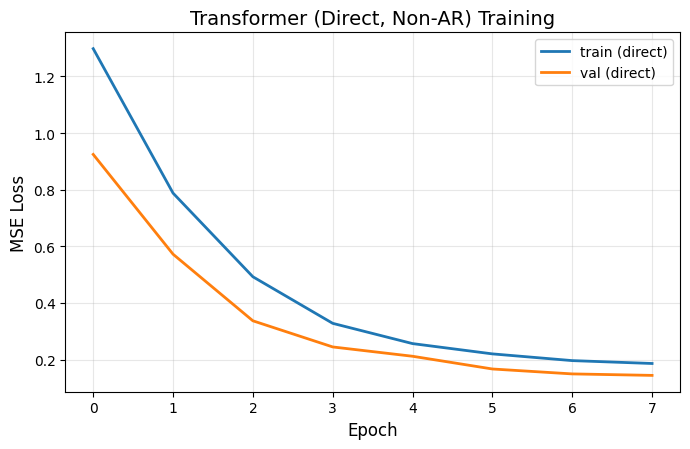

Generating forecast visualization...


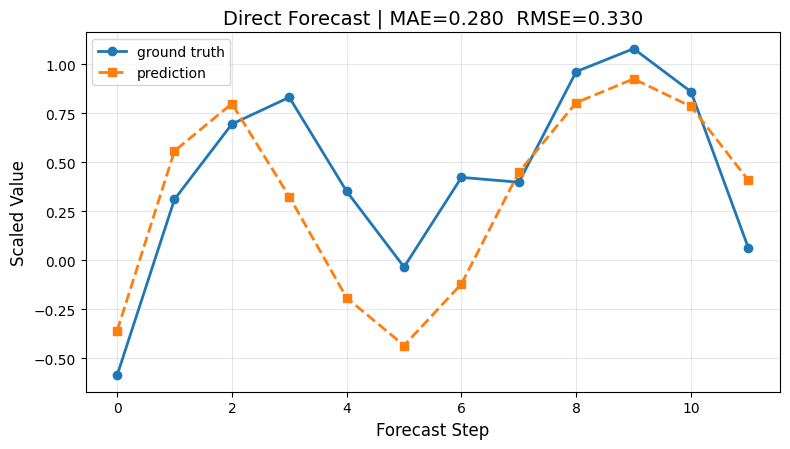


DEMO COMPLETE
Notes:
  - Direct (non-AR) makes a one-shot horizon prediction via cross-attention to encoder memory.
  - If you have known future covariates (calendar, promos), set cfg.future_cov_dim>0 and pass them to forward_direct().


In [5]:
# ts_transformer_cuda_demo.py
# Transformer for Time Series Forecasting — AR and Informer-like Non-AR (Direct) modes

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

# =============================================================================
# 0) RUNTIME / DEVICE SETTINGS
# =============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

USE_AMP = (DEVICE == "cuda")
USE_BF16 = USE_AMP and torch.cuda.is_bf16_supported()
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16
SCALER_ENABLED = USE_AMP and (not USE_BF16)

torch.manual_seed(7)
np.random.seed(7)

# =============================================================================
# 1) ATTENTION MASK UTILITIES
# =============================================================================

def subsequent_mask(sz: int) -> torch.Tensor:
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool, device="cpu"), diagonal=1)
    return mask.view(1, 1, sz, sz)

def merge_padding_mask(attn_shape: Tuple[int, int, int, int],
                       key_padding_mask: Optional[torch.Tensor]) -> Optional[torch.Tensor]:
    if key_padding_mask is None:
        return None
    b, t_k = key_padding_mask.shape
    _, h, t_q, _ = attn_shape
    return key_padding_mask.view(b, 1, 1, t_k).expand(b, h, t_q, t_k)

# =============================================================================
# 2) POSITIONAL ENCODINGS
# =============================================================================

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) *
            -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T = x.size(1)
        return x + self.pe[:T, :]

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        self.embed = nn.Embedding(max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        return x + self.embed(pos)

# =============================================================================
# 3) TRANSFORMER BLOCKS
# =============================================================================

class PreNormResidual(nn.Module):
    def __init__(self, d_model: int, block: nn.Module, dropout: float = 0.0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.block = block
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        return x + self.drop(self.block(self.norm(x), *args, **kwargs))

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0, activation: str = "gelu"):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = F.gelu if activation == "gelu" else F.relu

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.drop(self.act(self.lin1(x))))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0
        self.h = num_heads
        self.d_head = d_model // num_heads
        self.q_proj = nn.Linear(d_model, d_model, bias=bias)
        self.k_proj = nn.Linear(d_model, d_model, bias=bias)
        self.v_proj = nn.Linear(d_model, d_model, bias=bias)
        self.o_proj = nn.Linear(d_model, d_model, bias=bias)
        self.drop = nn.Dropout(dropout)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_head).permute(0, 2, 1, 3)

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        B, H, T, Dh = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None) -> torch.Tensor:
        Q = self._split_heads(self.q_proj(q))
        K = self._split_heads(self.k_proj(k))
        V = self._split_heads(self.v_proj(v))
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)
        neg_inf = torch.finfo(scores.dtype).min
        if key_padding_mask is not None:
            kpm = merge_padding_mask(scores.shape, key_padding_mask)
            scores = scores.masked_fill(kpm, neg_inf)
        if attn_mask is not None:
            if attn_mask.device != scores.device:
                attn_mask = attn_mask.to(scores.device)
            scores = scores.masked_fill(attn_mask, neg_inf)
        attn = torch.softmax(scores, dim=-1)
        attn = self.drop(attn)
        out = torch.matmul(attn, V)
        out = self._combine_heads(out)
        return self.o_proj(out)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        self.mha = PreNormResidual(d_model, MultiHeadAttention(d_model, num_heads, attn_dropout))
        self.ffn = PreNormResidual(d_model, FeedForward(d_model, d_ff, ff_dropout, activation))

    def forward(self, x, key_padding_mask=None):
        x = self.mha(x, x, x, attn_mask=None, key_padding_mask=key_padding_mask)
        x = self.ffn(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        self.self_attn = PreNormResidual(d_model, MultiHeadAttention(d_model, num_heads, attn_dropout))
        self.cross_attn = PreNormResidual(d_model, MultiHeadAttention(d_model, num_heads, attn_dropout))
        self.ffn = PreNormResidual(d_model, FeedForward(d_model, d_ff, ff_dropout, activation))

    def forward(self, x, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        x = self.self_attn(x, x, x, attn_mask=self_attn_mask, key_padding_mask=self_key_padding_mask)
        x = self.cross_attn(x, mem, mem, attn_mask=None, key_padding_mask=mem_key_padding_mask)
        x = self.ffn(x)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, key_padding_mask=None):
        for layer in self.layers:
            x = layer(x, key_padding_mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask):
        for layer in self.layers:
            y = layer(y, mem, self_attn_mask, self_key_padding_mask, mem_key_padding_mask)
        return self.norm(y)

# ---- Non-AR (Informer-like) decoder ----------------------------------------

class NonARDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0, activation="gelu"):
        super().__init__()
        self.cross_attn = PreNormResidual(d_model, MultiHeadAttention(d_model, num_heads, attn_dropout))
        self.ffn       = PreNormResidual(d_model, FeedForward(d_model, d_ff, ff_dropout, activation))

    def forward(self, q, mem, mem_key_padding_mask=None):
        q = self.cross_attn(q, mem, mem, attn_mask=None, key_padding_mask=mem_key_padding_mask)
        q = self.ffn(q)
        return q

class NonARDecoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, attn_dropout=0.0, ff_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            NonARDecoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, q, mem, mem_key_padding_mask=None):
        for layer in self.layers:
            q = layer(q, mem, mem_key_padding_mask)
        return self.norm(q)

class FutureQueryEmbedding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000, cov_dim: int = 0, pos_type: str = "sin"):
        super().__init__()
        self.cov_dim = cov_dim
        # If no covariates, we'll project a learned base query (same shape) via Linear
        in_dim = cov_dim if cov_dim > 0 else d_model
        self.proj = nn.Linear(in_dim, d_model)
        if pos_type == "sin":
            self.pos = SinusoidalPositionalEncoding(d_model, max_len)
        else:
            self.pos = LearnedPositionalEncoding(d_model, max_len)
        self.base_query = nn.Parameter(torch.zeros(1, 1, d_model))

    def forward(self, T_y: int, B: int, device, future_cov: Optional[torch.Tensor] = None):
        if future_cov is None:
            q = self.base_query.expand(B, T_y, -1)
            q = self.proj(q)
        else:
            assert future_cov.dim() == 3 and future_cov.size(1) == T_y
            q = self.proj(future_cov)
        q = self.pos(q)
        return q

# =============================================================================
# 4) COMPLETE MODEL
# =============================================================================

@dataclass
class TSTConfig:
    d_model: int = 128
    num_encoder_layers: int = 3
    num_decoder_layers: int = 2
    num_heads: int = 8
    d_ff: int = 256
    dropout: float = 0.1
    pos_encoding: str = "sin"      # "sin" or "learned"
    max_len: int = 4096
    input_dim: int = 4
    target_dim: int = 1
    dec_input_dim: int = 1
    output_activation: Optional[str] = None     # "tanh"|"sigmoid"|None
    predict_mode: str = "ar"                    # "ar" or "direct"
    future_cov_dim: int = 0                     # if >0, pass future covs into direct path

class TimeSeriesTransformer(nn.Module):
    def __init__(self, cfg: TSTConfig):
        super().__init__()
        self.cfg = cfg

        self.enc_in = nn.Linear(cfg.input_dim, cfg.d_model)
        self.dec_in = nn.Linear(cfg.dec_input_dim, cfg.d_model)

        if cfg.pos_encoding == "sin":
            self.pos_enc = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = SinusoidalPositionalEncoding(cfg.d_model, cfg.max_len)
        else:
            self.pos_enc = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)
            self.pos_dec = LearnedPositionalEncoding(cfg.d_model, cfg.max_len)

        self.enc = Encoder(cfg.d_model, cfg.num_encoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        self.dec = Decoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                           attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)

        # Non-AR (Informer-like) path
        self.dec_nonar = NonARDecoder(cfg.d_model, cfg.num_decoder_layers, cfg.num_heads, cfg.d_ff,
                                      attn_dropout=cfg.dropout, ff_dropout=cfg.dropout)
        self.future_q = FutureQueryEmbedding(cfg.d_model, cfg.max_len,
                                             cov_dim=cfg.future_cov_dim, pos_type=cfg.pos_encoding)

        self.head = nn.Linear(cfg.d_model, cfg.target_dim)
        self.drop_in = nn.Dropout(cfg.dropout)

        self.out_act = None
        if cfg.output_activation == "tanh":
            self.out_act = torch.tanh
        elif cfg.output_activation == "sigmoid":
            self.out_act = torch.sigmoid

    # -------- AR teacher-forced forward (training/eval) ----------
    def forward(self, X, y_in, src_key_padding_mask=None, tgt_key_padding_mask=None):
        x = self.drop_in(self.pos_enc(self.enc_in(X)))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)
        y  = self.drop_in(self.pos_dec(self.dec_in(y_in)))
        self_mask = subsequent_mask(y.size(1)).to(y.device)
        out = self.dec(y, mem, self_mask, tgt_key_padding_mask, src_key_padding_mask)
        logits = self.head(out)
        return logits if self.out_act is None else self.out_act(logits)

    # -------- AR autoregressive generation (inference) -----------
    @torch.no_grad()
    def generate(self, X, y_start, steps, src_key_padding_mask=None):
        device = X.device
        x = self.pos_enc(self.enc_in(X))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)
        preds = []
        y_seq = y_start
        for _ in range(steps):
            y_dec = self.pos_dec(self.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = self.dec(y_dec, mem, self_mask, None, src_key_padding_mask)
            next_logits = self.head(out[:, -1:, :])
            next_value = next_logits if self.out_act is None else self.out_act(next_logits)
            preds.append(next_value)
            if self.cfg.dec_input_dim == self.cfg.target_dim:
                y_seq = torch.cat([y_seq, next_value], dim=1)
            else:
                if self.cfg.dec_input_dim > self.cfg.target_dim:
                    pad = torch.zeros(X.size(0), 1, self.cfg.dec_input_dim - self.cfg.target_dim, device=device)
                    y_seq = torch.cat([y_seq, torch.cat([next_value, pad], dim=-1)], dim=1)
                else:
                    y_seq = torch.cat([y_seq, next_value[..., :self.cfg.dec_input_dim]], dim=1)
        return torch.cat(preds, dim=1)

    # -------- Non-AR (direct) whole-horizon forward -------------
    def forward_direct(self, X, T_y: int, src_key_padding_mask=None, future_cov: Optional[torch.Tensor] = None):
        device = X.device
        B = X.size(0)
        x = self.drop_in(self.pos_enc(self.enc_in(X)))
        mem = self.enc(x, key_padding_mask=src_key_padding_mask)          # [B, T_x, D]
        q = self.future_q(T_y=T_y, B=B, device=device, future_cov=future_cov)  # [B, T_y, D]
        out = self.dec_nonar(q, mem, mem_key_padding_mask=src_key_padding_mask)  # [B, T_y, D]
        logits = self.head(out)
        return logits if self.out_act is None else self.out_act(logits)

# =============================================================================
# 5) SYNTHETIC DATASET
# =============================================================================

def make_sine_mix(n_series: int, length: int, n_features: int, seed: int = 0):
    rng = np.random.default_rng(seed)
    t = np.arange(length)
    X = np.zeros((n_series, length, n_features), dtype=np.float32)
    y = np.zeros((n_series, length, 1), dtype=np.float32)
    for i in range(n_series):
        f1, f2 = rng.uniform(0.01, 0.08), rng.uniform(0.08, 0.15)
        p1, p2 = rng.uniform(0, 2*np.pi), rng.uniform(0, 2*np.pi)
        trend = rng.uniform(-0.002, 0.002) * t
        noise = rng.normal(0, 0.05, size=length)
        base = 0.6*np.sin(2*np.pi*f1*t + p1) + 0.4*np.sin(2*np.pi*f2*t + p2) + trend + noise
        feat0 = base
        feat1 = np.cos(2*np.pi*0.03*t + p1)
        feat2 = np.roll(base, 3)
        feat3 = 0.5*(base**2)
        feats = np.stack([feat0, feat1, feat2, feat3], axis=-1).astype(np.float32)[:, :n_features]
        X[i] = feats
        y[i, :, 0] = np.tanh(base + 0.1*feat1).astype(np.float32)
    X_mean = X.mean(axis=(0,1), keepdims=True)
    X_std  = X.std(axis=(0,1), keepdims=True) + 1e-6
    y_mean = y.mean(axis=(0,1), keepdims=True)
    y_std  = y.std(axis=(0,1), keepdims=True) + 1e-6
    X = (X - X_mean) / X_std
    y = (y - y_mean) / y_std
    return X, y, {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}

class WindowedTS(Dataset):
    def __init__(self, X, y, T_x: int, T_y: int):
        self.X = X
        self.y = y
        self.T_x = T_x
        self.T_y = T_y
        self.length = X.shape[1]
        self.index = []
        for i in range(X.shape[0]):
            for t in range(self.length - (T_x + T_y) + 1):
                self.index.append((i, t))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        i, t = self.index[idx]
        Xw = self.X[i, t:t+self.T_x, :].copy()
        y_future = self.y[i, t+self.T_x:t+self.T_x+self.T_y, :].copy()
        y_in = np.zeros((self.T_y, 1), dtype=np.float32)
        y_in[1:, 0] = y_future[:-1, 0]
        return torch.from_numpy(Xw), torch.from_numpy(y_in), torch.from_numpy(y_future)

# =============================================================================
# 6) AR TRAINING UTILITIES (Scheduled Sampling)
# =============================================================================

@torch.no_grad()
def _bernoulli_mask(batch: int, p_tf: float, device):
    return (torch.rand(batch, 1, 1, device=device) < p_tf)

def scheduled_sampling_step(
    model: TimeSeriesTransformer,
    Xb: torch.Tensor,
    ytrue: torch.Tensor,
    p_tf: float,
) -> torch.Tensor:
    assert model.cfg.dec_input_dim == model.cfg.target_dim == ytrue.size(-1), \
        "scheduled_sampling_step assumes dec_input_dim == target_dim."
    device = Xb.device
    B, T_y, _ = ytrue.shape
    x = model.pos_enc(model.enc_in(Xb))
    mem = model.enc(x, key_padding_mask=None)
    preds = []
    y_seq = ytrue[:, :1, :]
    with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
        for t in range(T_y):
            y_dec = model.pos_dec(model.dec_in(y_seq))
            self_mask = subsequent_mask(y_dec.size(1)).to(device)
            out = model.dec(y_dec, mem, self_mask, None, None)
            step_pred = model.head(out[:, -1:, :])
            if model.out_act is not None:
                step_pred = model.out_act(step_pred)
            preds.append(step_pred)
            if t == T_y - 1:
                break
            use_teacher = _bernoulli_mask(B, p_tf, device)
            next_input = torch.where(use_teacher, ytrue[:, t:t+1, :], step_pred)
            y_seq = torch.cat([y_seq, next_input], dim=1)
    return torch.cat(preds, dim=1).float()

# =============================================================================
# 7) DIRECT (Non-AR) TRAINING UTILITIES
# =============================================================================

def run_epoch_direct(model, loader, train: bool, T_y: int, opt=None, scaler=None):
    model.train(train)
    total, n = 0.0, 0
    for Xb_cpu, _, ytrue_cpu in loader:
        Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
        y  = ytrue_cpu.to(DEVICE, non_blocking=True).float()
        if train and opt is not None:
            opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
            pred = model.forward_direct(Xb, T_y=T_y)
            loss = F.mse_loss(pred.float(), y)
        if train and opt is not None:
            if scaler is not None and scaler.is_enabled():
                scaler.scale(loss).backward()
                nn.utils.clip_grad_norm_((model.parameters()), 1.0)
                scaler.step(opt); scaler.update()
            else:
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
        total += loss.item() * Xb.size(0)
        n     += Xb.size(0)
    return total / max(1, n)

# =============================================================================
# 8) TRAINING LOOP (Supports AR and DIRECT)
# =============================================================================

def train_transformer(
    EPOCHS=8,
    N_SAMPLES=120,
    SERIES_LENGTH=320,
    T_X=72,
    T_Y=36,
    BATCH=128,
    LR=1e-3,
    TF_START=0.9,
    TF_END=0.5,
    MODE: str = "ar"   # "ar" or "direct"
):
    print("=" * 70)
    print("GENERATING SYNTHETIC DATA")
    print("=" * 70)
    X, y, stats = make_sine_mix(n_series=N_SAMPLES, length=SERIES_LENGTH, n_features=4, seed=42)
    print(f"Generated {N_SAMPLES} series of length {SERIES_LENGTH}")
    print(f"Features shape: {X.shape}, Targets shape: {y.shape}")
    ds = WindowedTS(X, y, T_X, T_Y)
    print(f"Total windows: {len(ds)} (history={T_X}, forecast={T_Y})")
    n_train = int(0.8 * len(ds))
    n_val = len(ds) - n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    print(f"Train windows: {n_train}, Val windows: {n_val}\n")
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)

    print("=" * 70)
    print("INITIALIZING MODEL")
    print("=" * 70)
    cfg = TSTConfig(predict_mode=MODE)
    model = TimeSeriesTransformer(cfg).to(DEVICE)
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {n_params:,}")
    print(f"Device: {DEVICE}")
    print(f"Mixed precision: {'BFloat16' if USE_BF16 else 'Float16' if USE_AMP else 'Float32'}\n")
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(device="cuda", enabled=SCALER_ENABLED)

    def tf_prob_for_epoch(ep, total):
        alpha = (ep - 1) / max(1, total - 1)
        return TF_START * (1 - alpha) + TF_END * alpha

    print("=" * 70)
    print(f"TRAINING ({MODE.upper()})")
    print("=" * 70)

    if MODE == "direct":
        history = {"train": [], "val": []}
        for ep in range(1, EPOCHS+1):
            train_loss = run_epoch_direct(model, train_loader, train=True, T_y=T_Y, opt=opt, scaler=scaler)
            val_loss   = run_epoch_direct(model,   val_loader, train=False, T_y=T_Y)
            sched.step()
            print(f"Epoch {ep:02d} | direct | train={train_loss:.4f} | val={val_loss:.4f} | lr={sched.get_last_lr()[0]:.2e}")
            history["train"].append(train_loss)
            history["val"].append(val_loss)
        # Pack outputs similar to AR branch
        extra_hist = {"val_tf": history["val"], "val_free": history["val"]}
    else:
        history = {"train": [], "val_tf": [], "val_free": []}

        def run_epoch_ar(loader, train: bool, p_tf: float):
            model.train(train)
            total_loss = 0.0
            n_samples = 0
            for Xb_cpu, _, ytrue_cpu in loader:
                Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()
                opt.zero_grad(set_to_none=True)
                pred = scheduled_sampling_step(model, Xb, ytrue, p_tf=p_tf)
                loss = F.mse_loss(pred, ytrue)
                if train:
                    if scaler.is_enabled():
                        scaler.scale(loss).backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        scaler.step(opt); scaler.update()
                    else:
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        opt.step()
                total_loss += loss.item() * Xb.size(0)
                n_samples  += Xb.size(0)
            return total_loss / max(1, n_samples)

        for ep in range(1, EPOCHS+1):
            p_tf = tf_prob_for_epoch(ep, EPOCHS)
            train_loss = run_epoch_ar(train_loader, train=True, p_tf=p_tf)
            # val_tf
            model.train(False)
            val_tf_total, val_n = 0.0, 0
            for Xb_cpu, y_in_cpu, ytrue_cpu in val_loader:
                Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                y_in = y_in_cpu.to(DEVICE, non_blocking=True).float()
                ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()
                with torch.amp.autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
                    pred_tf = model(Xb, y_in)
                loss_tf = F.mse_loss(pred_tf.float(), ytrue)
                val_tf_total += loss_tf.item() * Xb.size(0)
                val_n += Xb.size(0)
            val_tf = val_tf_total / max(1, val_n)
            # val_free
            val_free_total, val_n = 0.0, 0
            with torch.no_grad():
                for Xb_cpu, _, ytrue_cpu in val_loader:
                    Xb = Xb_cpu.to(DEVICE, non_blocking=True).float()
                    ytrue = ytrue_cpu.to(DEVICE, non_blocking=True).float()
                    y_start = ytrue[:, :1, :]
                    pred_free = model.generate(Xb, y_start=y_start, steps=T_Y).float()
                    loss_free = F.mse_loss(pred_free, ytrue)
                    val_free_total += loss_free.item() * Xb.size(0)
                    val_n += Xb.size(0)
            val_free = val_free_total / max(1, val_n)
            sched.step()
            print(f"Epoch {ep:02d} | p_tf={p_tf:.2f} | train={train_loss:.4f} | val_tf={val_tf:.4f} | val_free={val_free:.4f} | lr={sched.get_last_lr()[0]:.2e}")
            history["train"].append(train_loss)
            history["val_tf"].append(val_tf)
            history["val_free"].append(val_free)
        extra_hist = {}

    print("\n" + "=" * 70)
    print("TRAINING COMPLETE")
    print("=" * 70)
    if MODE == "direct":
        print(f"Final train loss: {history['train'][-1]:.4f}")
        print(f"Final val loss:   {history['val'][-1]:.4f}")
    else:
        print(f"Final train loss: {history['train'][-1]:.4f}")
        print(f"Final val_tf loss: {history['val_tf'][-1]:.4f}")
        print(f"Final val_free loss: {history['val_free'][-1]:.4f}")
        print(f"Exposure bias gap: {history['val_free'][-1] - history['val_tf'][-1]:.4f}")

    # Return uniform shape
    if MODE == "direct" and "val_tf" not in history:
        history.update(extra_hist)

    return model, (train_loader, val_loader), history, (X, y, stats), (T_X, T_Y), MODE

# =============================================================================
# 9) DEMO + VISUALIZATIONS
# =============================================================================

if __name__ == "__main__":
    print("\n" + "=" * 70)
    print("TIME SERIES TRANSFORMER DEMO (AR + DIRECT)")
    print("=" * 70)

    # Choose: "ar" or "direct"
    MODE = "direct"  # change to "ar" to use autoregressive training/eval

    model, (train_loader, val_loader), history, (X_all, y_all, stats), (T_X, T_Y), MODE = train_transformer(
        EPOCHS=8,
        N_SAMPLES=120,
        SERIES_LENGTH=320,
        T_X=24,
        T_Y=12,
        BATCH=512,
        LR=1e-3,
        TF_START=0.9,
        TF_END=0.5,
        MODE=MODE
    )

    print("Generating training curves...")
    plt.figure(figsize=(7, 4.6))
    if MODE == "direct":
        plt.plot(history["train"], label="train (direct)", linewidth=2)
        plt.plot(history["val"],   label="val (direct)", linewidth=2)
        title = "Transformer (Direct, Non-AR) Training"
    else:
        plt.plot(history["train"],   label="train (scheduled sampling)", linewidth=2)
        plt.plot(history["val_tf"],  label="val teacher-forced", linewidth=2)
        plt.plot(history["val_free"],label="val free-running", linewidth=2)
        title = "Transformer (AR) Training with Scheduled Sampling"
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("MSE Loss", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Generating forecast visualization...")
    DEVICE = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        Xb_cpu, y_in_cpu, ytrue_cpu = next(iter(val_loader))
        Xb = Xb_cpu[:1].to(DEVICE).float()
        ytrue = ytrue_cpu[:1].to(DEVICE).float()
        if MODE == "direct":
            pred = model.forward_direct(Xb, T_y=T_Y).float()
        else:
            y_start = ytrue[:, :1, :]
            pred = model.generate(Xb, y_start=y_start, steps=T_Y).float()

    gt = ytrue[0, :, 0].detach().cpu().numpy()
    pr = pred[0, :, 0].detach().cpu().numpy()
    mae = np.mean(np.abs(pr - gt))
    rmse = np.sqrt(np.mean((pr - gt) ** 2))

    plt.figure(figsize=(8, 4.6))
    plt.plot(np.arange(T_Y), gt, 'o-', label="ground truth", linewidth=2, markersize=6)
    plt.plot(np.arange(T_Y), pr, 's--', label="prediction", linewidth=2, markersize=6)
    plt.xlabel("Forecast Step", fontsize=12)
    plt.ylabel("Scaled Value", fontsize=12)
    plt.title(f"{'Direct' if MODE=='direct' else 'AR'} Forecast | MAE={mae:.3f}  RMSE={rmse:.3f}", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("DEMO COMPLETE")
    print("=" * 70)
    if MODE == "direct":
        print("Notes:")
        print("  - Direct (non-AR) makes a one-shot horizon prediction via cross-attention to encoder memory.")
        print("  - If you have known future covariates (calendar, promos), set cfg.future_cov_dim>0 and pass them to forward_direct().")
    else:
        print("Notes:")
        print("  - AR training uses scheduled sampling; validation reports teacher-forced and free-running.")
        print("  - Exposure bias is visible as the (val_free - val_tf) gap.")
